# INTRO

This is an exercise on machine learning, focusing on EDA and classification algorithm, in this case, the algorithm used is **Random Forest Classifier**.

The data source can be accessed [here][1]. <br>

[1]: https://www.kaggle.com/ronitf/heart-disease-uci

In [1]:
import logging
logging.captureWarnings(True)

import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

%matplotlib inline

### About this dataset
- **Age** : Age of the patient

- **Sex** : Sex of the patient

- **exang**: exercise induced angina (1 = yes; 0 = no)

- **ca**: number of major vessels (0-3)

- **cp** : Chest Pain type chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic

- **trestbps** : resting blood pressure (in mm Hg)

- **chol** : cholestoral in mg/dl fetched via BMI sensor

- **fbs** : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

- **restecg** : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

- **thalach** : maximum heart rate achieved

- **target** : 0= less chance of heart attack 1= more chance of heart attack

In [2]:
heart = pd.read_csv('heart.csv')

# swap the heart attack condition, it suspected to be swapped from the source dataset
heart['target'] = heart['target'].apply(lambda x: 1 if x == 0 else 0)

# renaming the column header
heart.columns = ['Age', 
                 'Sex', 
                 'Chest Pain Type', 
                 'Resting Blood Pressure',
                 'Cholesterol',
                 'Fasting Blood Sugar', 
                 'Resting ECG', 
                 'Max. HR Achieved',
                 'Exercise Induced Angina', 
                 'ST Depression', 
                 'ST Slope', 
                 'Num. Major Blood Vessels', 
                 'Thalassemia', 
                 'Condition'
                ]

heart.head()

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max. HR Achieved,Exercise Induced Angina,ST Depression,ST Slope,Num. Major Blood Vessels,Thalassemia,Condition
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


## Exploratory Data Analysis TL;DR

In this section, we will analyze our data while also cleaning the data, mostly renaming the column and swapping the condition since it is suspected has been swapped from the correct one.

Our Exploratory Data Analysis (EDA) will include:
- [Checking on null values](#Checking-on-null-value)<br>
  We have 303 records with **no null values**.
- [Checking data balance](#Checking-data-balance) <br>
  The data is relatively **balanced** with ~45% condition 1 and ~55% condition 0.
- [Analyzing continuous parameters using KDE plot and its overlapped/intersection value](#Analyzing-Continuous-Features-Using-KDE-Plot) <br>
  **Resting blood pressure** and **Cholesterol** seems to be **unable** to better distinguish between condition 1 and 0. This is indicated by their high intersection value.
- [Analyzing categorical parameters using bar plot and its absolute difference value](#Analyzing-Categorical-Features-Using-Bar-Plot) <br>
  Some of the categorical parameters seem to have a value which **better differentiates** between condition 1 and 0.
- [Risk analysis](#Risk-Analysis) <br>
  Align with the analysis on continuous parameters. **Resting blood pressure** and **Cholesterol** have a fluctuative pattern. As it increases, the risk of having heart attack seems relatively stable.
- [Revisiting the parameters](#Continuous-Features-vs-Gender) <br>
  From the categorical analysis, `Sex` seems to differ the data widely. The data we have implies, that `Sex = 0` have much lower probability of having `Condition = 1`. Hence the interest of looking at how `Sex` differ on both condition for the rest of the parameters
- [Parameter correlation using heatmap](#Correlation-Heatmap)
  

In [3]:
heart.describe()

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max. HR Achieved,Exercise Induced Angina,ST Depression,ST Slope,Num. Major Blood Vessels,Thalassemia,Condition
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.455446
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,0.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [4]:
# converting the data types accordingly
categorical = heart.columns[heart.nunique()<=4]

for i in categorical:
    heart[i] = heart[i].astype("category")

print(heart.info(),'\n')
print(heart.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       303 non-null    int64   
 1   Sex                       303 non-null    category
 2   Chest Pain Type           303 non-null    category
 3   Resting Blood Pressure    303 non-null    int64   
 4   Cholesterol               303 non-null    int64   
 5   Fasting Blood Sugar       303 non-null    category
 6   Resting ECG               303 non-null    category
 7   Max. HR Achieved          303 non-null    int64   
 8   Exercise Induced Angina   303 non-null    category
 9   ST Depression             303 non-null    float64 
 10  ST Slope                  303 non-null    category
 11  Num. Major Blood Vessels  303 non-null    int64   
 12  Thalassemia               303 non-null    category
 13  Condition                 303 non-null    category

### Checking on null value

**We don't have to worry about null value because none of the column has null value**

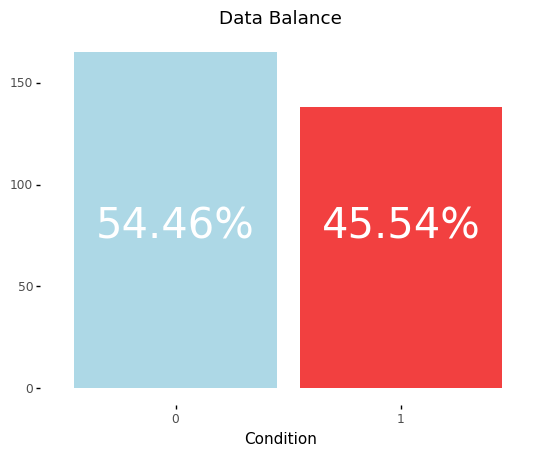

<ggplot: (-9223371905884781772)>

In [5]:
# checking data balance

(ggplot(heart)
 + aes(x = 'Condition', fill = 'Condition')
 + geom_bar(show_legend=False)
 + annotate('text', x=1, y = 80, 
            label="{:.2%}".format(heart.Condition.value_counts().iloc[0]/heart.Condition.value_counts().sum()), 
            color = 'white', size = 30)
 + annotate('text', x=2, y = 80, 
            label="{:.2%}".format(heart.Condition.value_counts().iloc[1]/heart.Condition.value_counts().sum()), 
            color = 'white', size = 30)
 + theme_bw()
 + theme(
    plot_background = element_blank(),
    panel_grid_major = element_blank(),
    panel_grid_minor = element_blank(),
    panel_border = element_blank(),
  )
 + labs(title = 'Data Balance', y = '')
 + scale_fill_manual(values = ("lightblue","#F24040"))
)

### Checking data balance

The dataset we have seems balanced.

However, heart attack is actually a somewhat rare diseases. This balanced dataset probably won't picture the realest condition of our world, therefore there may be an overestimation of heart attack probability on our machine learning model later.

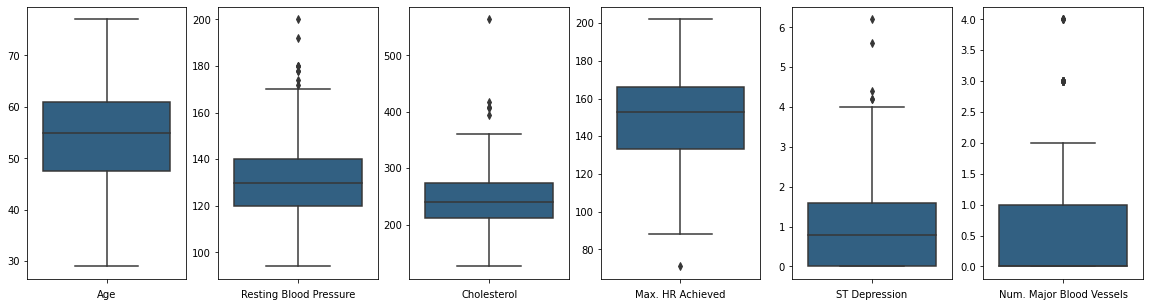

In [6]:
fig, ax = plt.subplots(1,len(heart.select_dtypes(exclude=['category']).columns), figsize = (20,5))

for i,j in zip(heart.select_dtypes(exclude=['category']).columns, range(len(heart.select_dtypes(exclude=['category']).columns))):
    g = sns.boxplot(data = heart, y = i, ax=ax[j], color = '#25628f')
    g.set_ylabel('')
    g.set_xlabel(i)

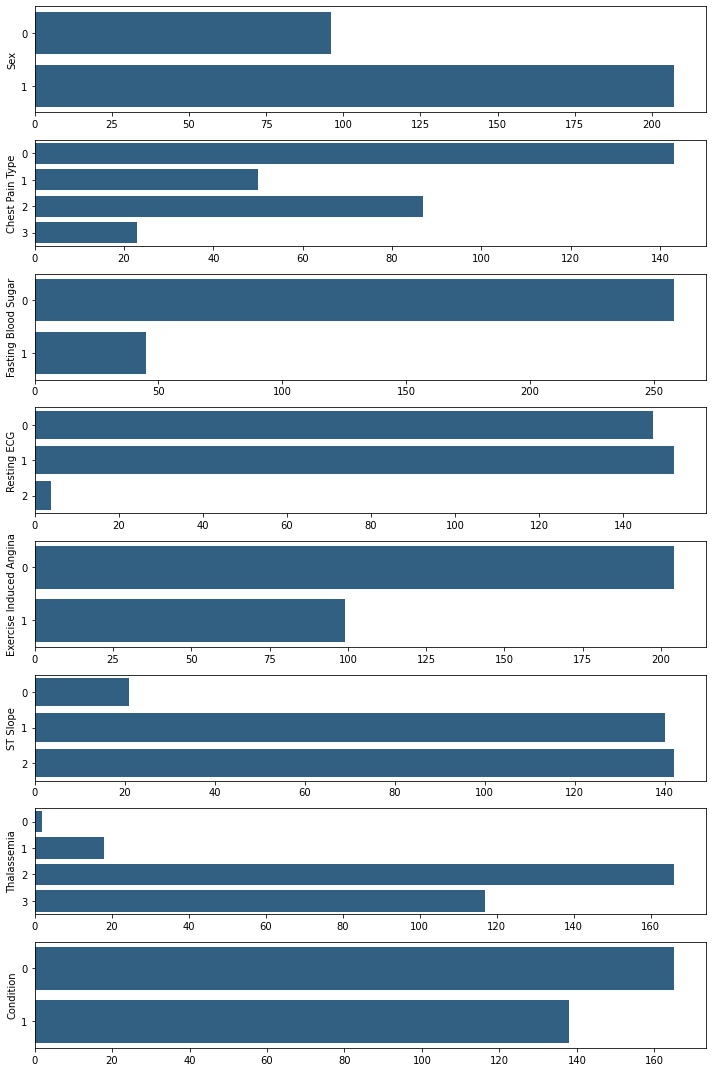

In [7]:
fig, ax = plt.subplots(len(heart.select_dtypes(include=['category']).columns),1,figsize = (10,15))

for i,j in zip(heart.select_dtypes(include=['category']).columns, range(len(heart.select_dtypes(include=['category']).columns))):
    g = sns.countplot(data = heart, y = i, ax=ax[j], color = '#25628f')
#     g = sns.color_palette("light:#5A9", as_cmap=True)
    g.set_ylabel(i)
    g.set_xlabel('')
plt.tight_layout()

In [8]:
# https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots-in-python

def kde_overlap_cal(parameter = 'Age'):
    x0 = heart.loc[heart['Condition'] == 0, str(parameter)]
    x1 = heart.loc[heart['Condition'] == 1, str(parameter)]

    kde0 = gaussian_kde(x0, bw_method=0.3)
    kde1 = gaussian_kde(x1, bw_method=0.3)

    xmin = min(x0.min(), x1.min())
    xmax = min(x0.max(), x1.max())
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx

    x = np.linspace(xmin, xmax, 500)
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    area_inters_x = np.trapz(inters_x, x)
    return(area_inters_x)

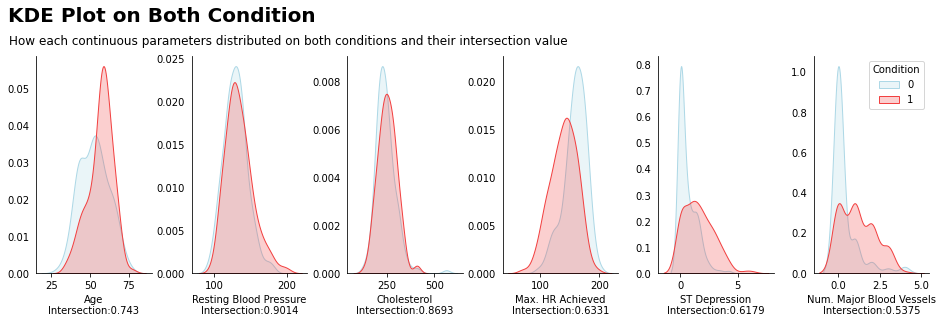

In [9]:
continuous = heart.select_dtypes(exclude = 'category').columns.tolist()

col = len(continuous)

fig,ax = plt.subplots(1,col,figsize = (16,4))
fig.subplots_adjust(wspace=0.35)
fig.suptitle("KDE Plot on Both Condition", x = 0.1, y = 1.05, 
             horizontalalignment = 'left', fontsize = 20, fontweight = 'bold')
plt.gcf().text(0.101,0.92, 'How each continuous parameters distributed on both conditions and their intersection value', fontsize=12)

for i,j in zip(continuous, range(col)):
    overlap = str(round(kde_overlap_cal(i),4))
    
    g1 = sns.kdeplot(heart[i][heart['Condition'] == 0], ax=ax[j],color='lightblue', shade=True, legend = False)
    g1 = sns.kdeplot(heart[i][heart['Condition'] == 1], ax=ax[j],color='#F24040', shade=True, legend = False)
    
    g1.set_xlabel(i+'\nIntersection:'+overlap)
    g1.set_ylabel('')
    g1.tick_params(left=False)
    g1.spines['top'].set_visible(False)
#     g1.spines['left'].set_visible(False)
    g1.spines['right'].set_visible(False)
    
#     g1.set(yticklabels=[])

plt.legend(title='Condition', loc='upper right', labels=[0, 1])

### Analyzing Continuous Features Using KDE Plot

From the graphs above, it seems that some of the parameters namely:
- Resting Blood Pressure
- Cholesterol

Can't easily distinguish between patient with high risk of heart attack. It is also supported by looking at their overlap between condition 1 and 0. Those 2 paramteres have the highest overlap, i.e. has no distinction between condition 1 and 2 throughout their values.

In [10]:
def cat_dif_cal(cat):
    temp_dict = {}
    for j in cat:
        temp = 0
        for i in heart[j].unique():
            temp = abs((len(heart[(heart['Condition'] == 1) & (heart[j] == i)]) - len(heart[(heart['Condition'] == 0) & (heart[j] == i)]))) + temp
        temp_dict[j] = temp
    return temp_dict

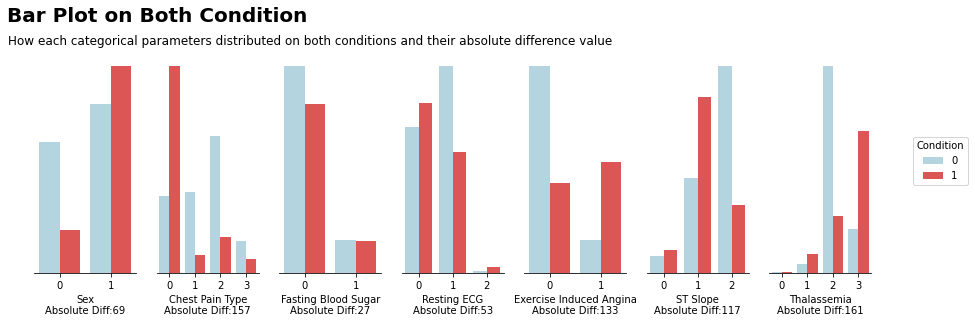

In [11]:
categorical = heart.select_dtypes(include = 'category').columns.tolist()
categorical.remove('Condition')

col2 = len(categorical)

dif = cat_dif_cal(categorical)

fig,ax = plt.subplots(1,col2,figsize = (15,4))
fig.suptitle("Bar Plot on Both Condition", x = 0.1, y = 1.05, 
             horizontalalignment = 'left', fontsize = 20, fontweight = 'bold')
plt.gcf().text(0.101,0.92, 'How each categorical parameters distributed on both conditions and their absolute difference value', fontsize=12)

for i,j in zip(categorical, range(col2)):        
    g2 = sns.countplot(data = heart, x = i, ax = ax[j], hue = 'Condition', palette=['lightblue',"#F24040"])
    
    g2.set_ylabel('')
    g2.set_xlabel(i+'\nAbsolute Diff:'+str(dif[i]))
    
    g2.tick_params(left=False)
    g2.spines['top'].set_visible(False)
    g2.spines['left'].set_visible(False)
    g2.spines['right'].set_visible(False)
    
    g2.set(yticklabels=[])
    g2.legend([],[], frameon=False)

plt.legend(title='Condition', bbox_to_anchor=(1.5, 0.15, 0.5, 0.5), labels=[0, 1])

### Analyzing Categorical Features Using Bar Plot

Even though, the absolute different is relatively small, it seems that 'Sex' has a strong distinction between condition 0 and 1. This indicated by the wide gap between `Sex = 1` which has a small difference between both conditions, in contrast to `Sex = 0` which have a wide gap between both condition. **We will revisit** `Sex` and its effect to the continuous parameters.

As for the other parameters, it seems that for several value, there are a distinction, namely:
1. Chest pain type 0 and 2
2. Exercise Induced Angina 0 and 1
3. ST Slope 1 and 2
4. Thalassemia 2 and 3

For all the parameters and the class mentioned above, they seem to have a distinction between both conditions. For `Num. Major Blood Vessels`, in general the higher the number, the more it moves toward condition 1, however, this is not the case for 4 `Num. Major Blood Vessels`

In [12]:
temp_df = pd.DataFrame(columns = ['x', 'y', 'cat'])
for k in continuous[0:-2]:
    for i in range(heart[k].min(), (heart[k].max())):
        temp_df.loc[len(temp_df)] = (i,
                                     sum(heart[(heart[k] <= i) & (heart['Condition'] == 1)][k].value_counts().values)/sum(heart[(heart[k] <= i)][k].value_counts().values),
                                     k)

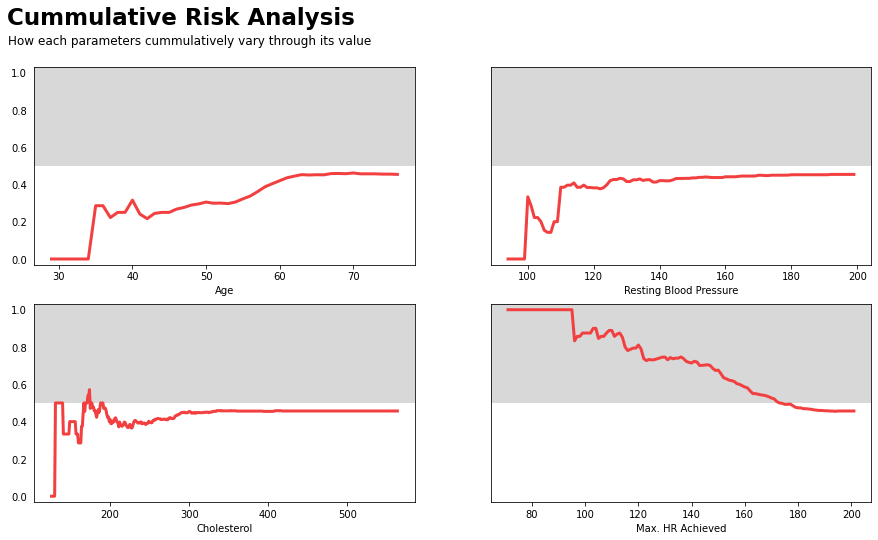

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (15,8),sharey=True)
fig.suptitle("Cummulative Risk Analysis", x = 0.1, y = 0.985, horizontalalignment = 'left', fontsize = 23, fontweight = 'bold')
plt.gcf().text(0.101,0.92, 'How each parameters cummulatively vary through its value', fontsize=12)

for col, ax in zip(continuous[0:-1], ax.flatten()):
    g = sns.lineplot(data = temp_df[temp_df['cat'] == col], x = 'x', y = 'y', 
                     ax = ax, 
                     color = '#F24040', linewidth=3)
    g.set_ylim(-0.03,1.03)
    g.axhspan(0.5, 1.03, facecolor='grey', alpha=0.3)
    g.set_xlabel(col)
    g.set_ylabel('')
    g.tick_params(left=False)

### Risk Analysis

Briefly, the graph depicts that the risk of having heart attack is lower as `Max. HR Achieved` increases. However, based on the data, this parameter is a high indication of having a heart attack because it mostly fall above the grey area.

The contrary happens to `Age` which increases the risk as they increase. 

Similar to our analysis using KDE plot no continuous parameters, according to this data, `Cholesterol` and `Resting Blood Pressure` don't play a big role due to its inconsistency as its move throughout the values.

_note: grey area indicates >= 50% risk of having heart attack_

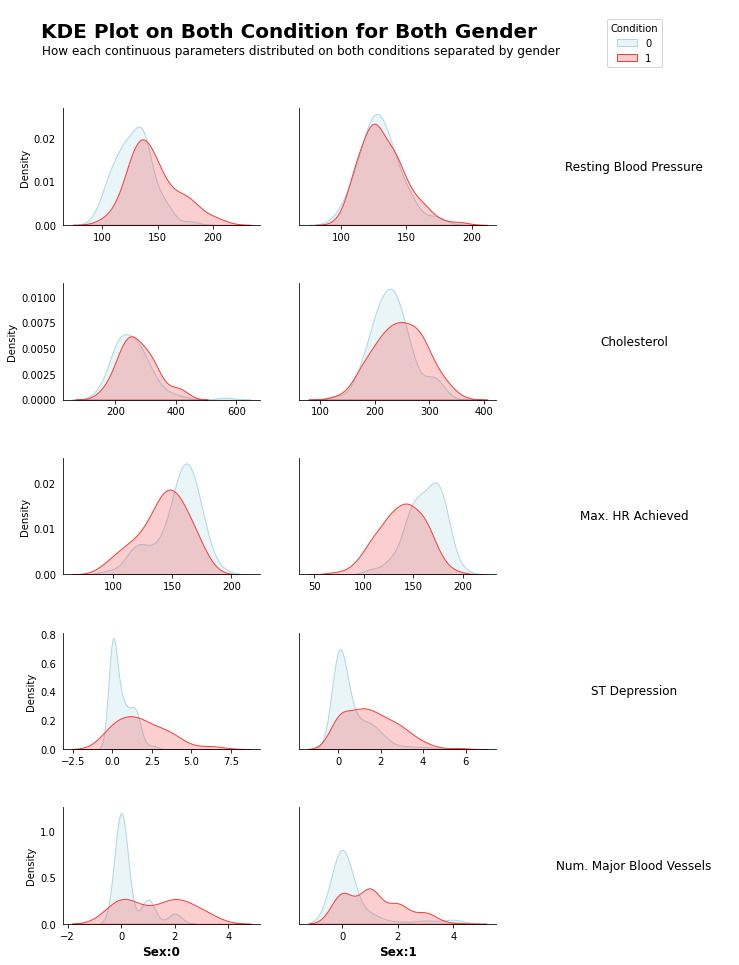

In [14]:
continuous = heart.select_dtypes(exclude = 'category').columns.tolist()

col = len(continuous)

fig,ax = plt.subplots(col-1,3,figsize = (12,15), sharey='row')
fig.subplots_adjust(hspace=0.5)

fig.suptitle("KDE Plot on Both Condition for Both Gender", 
             x = 0.1, y = 0.96, 
             horizontalalignment = 'left', fontsize = 20, fontweight = 'bold')
plt.gcf().text(0.101,0.93, 
               'How each continuous parameters distributed on both conditions separated by gender', 
               fontsize=12)

for i,j in zip(continuous[1:], range(col-1)):
    for sex in range(3):
        if sex != 3:
            g1 = sns.kdeplot(heart[i][(heart['Condition'] == 0) & (heart['Sex'] == sex)], 
                             ax=ax[j,sex],
                             color='lightblue', shade=True, 
                             legend = False)
            g1 = sns.kdeplot(heart[i][(heart['Condition'] == 1) & (heart['Sex'] == sex)], 
                             ax=ax[j,sex],
                             color='#F24040', shade=True, 
                             legend = False)

            g1.tick_params(left=False)
            g1.set_xlabel('')
            g1.spines['top'].set_visible(False)
            g1.spines['right'].set_visible(False)
        
        if sex == 2:
            g1.spines['bottom'].set_visible(False)
            g1.spines['left'].set_visible(False)
            g1.get_xaxis().set_ticks([])
            g1.text(0.5, 0.5, i, 
                    fontsize = 12,
                    horizontalalignment='center', verticalalignment='center', 
                    transform=g1.transAxes)
            
        if j == col-2:
            g1.set_xlabel('Sex:'+str(sex), fontsize = 12, fontweight = 'bold')
            if sex == 2:
                g1.set_xlabel('')
            
fig.legend(title='Condition', loc=[0.82,0.93], labels=[0, 1])

### Continuous Features vs Gender

In general, the graphs above indicate a pattern where `Sex: 0` has a tendency to be lower in all of the features, except for `Max. HR Achieved`. However, for `Sex: 1`, `Cholesterol` has a distincttive feature to distinguish from both condition, this is not the case for `Sex: 0`, this is perhaps why in our previous [Risk Analysis](#Risk-Analysis), `Cholesterol` seems not to play a big role.

<AxesSubplot:>

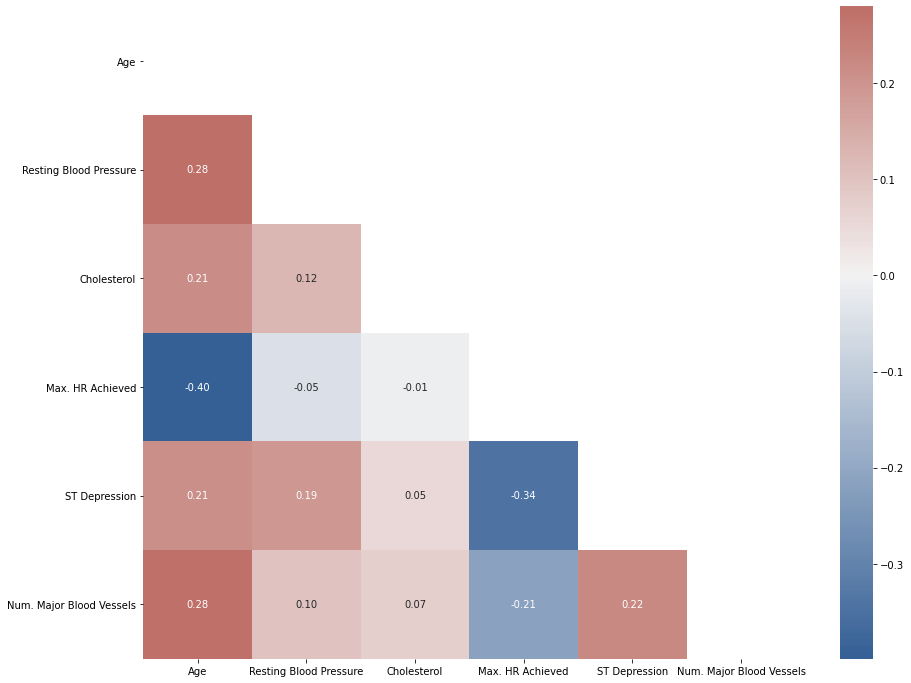

In [15]:
# https://www.kdnuggets.com/2021/04/awesome-tricks-best-practices-kaggle.html

# Calculate pairwise-correlation
matrix = heart.corr()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,n=9, 
                             center="light", 
                             as_cmap=True
                            )

plt.figure(figsize=(16, 12))

sns.heatmap(matrix, mask=mask, center=0, annot=True, 
            fmt='.2f', square=True, cmap=cmap)

# plt.show();

### Correlation Heatmap



## Machine Learning TL;DR

- Basic Machine Learning
- Hyper parameter tuning

In [16]:
# for splitting data
from sklearn.model_selection import train_test_split

# algos
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.model_selection import GridSearchCV

# these are the metrices will be used
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

# for visualization
from sklearn.tree import export_graphviz
from statsmodels.graphics.mosaicplot import mosaic

### Basic Machine Learning

In this section, we will do a basic machine learning using Random Forest Classifier. <br>
By basic I mean:
- No feature engineering
- Using default setting of the classifier

We will also look at the result of a random guess to get the sense of how good/bad the classifier is.

The machine learning process includes:
- Define feature and target
- Training and validation data splitting
- Define the classifier
- Fit the training data into the classifier
- Look at the feature importance
- Model evaluation using:
    - Confussion matrix
    - Specificity and Sensitivity
    - ROC AUC

In [17]:
# Separating the features (X) and target (y)
# In this iteration, all features will be used

features = heart.columns.values.tolist()
features.remove('Condition')

X = heart[features]

y = heart['Condition']

# Split into train and validation
random_state = 420
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=random_state)

In [18]:
dummy_clf = DummyClassifier(random_state = random_state)
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=420, strategy='stratified')

In [19]:
forest = RandomForestClassifier(random_state=random_state)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=420,
                       verbose=0, warm_start=False)

In [20]:
forest_feat = pd.DataFrame(columns = ['feature','importance'])

for i,j,k in zip(range(len(features)), features, forest.feature_importances_):
    forest_feat.loc[i] = j,k

In [21]:
forest_feat = forest_feat.sort_values(by = 'importance', ascending = False)
forest_feat = forest_feat.reset_index()
forest_feat = forest_feat.drop(columns = ['index'], axis = 1)
forest_feat['feature'] = pd.Categorical(forest_feat['feature'], categories=forest_feat['feature'])

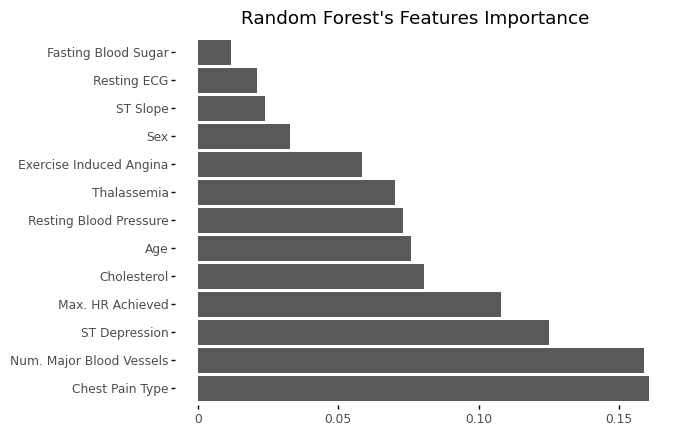

<ggplot: (-9223371905872980640)>

In [22]:
(ggplot(forest_feat)
 + aes(x = 'feature', y = 'importance')
 + geom_col()
 + theme_bw()
 + theme(
    plot_background = element_blank(),
    panel_grid_major = element_blank(),
    panel_grid_minor = element_blank(),
    panel_border = element_blank(),
  )
 + labs(title = "Random Forest's Features Importance", x = '', y = '')
 + coord_flip()
)

In [23]:
# model evaluation

# accuracy
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on validation set: {:.3f}".format(forest.score(X_val, y_val)))

print("Dummy Accuracy on training set: {:.3f}".format(dummy_clf.score(X_train, y_train)))
print("Dummy Accuracy on validation set: {:.3f}".format(dummy_clf.score(X_val, y_val)))

Accuracy on training set: 1.000
Accuracy on validation set: 0.711
Dummy Accuracy on training set: 0.493
Dummy Accuracy on validation set: 0.539


In [24]:
# Confussion matrix
val_pred = forest.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, val_pred).ravel()
conf_matrix = confusion_matrix(y_val, val_pred)
print(conf_matrix)
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)
print("True Positive:", tp)

[[29  6]
 [16 25]]
True Negative: 29
False Positive: 6
False Negative: 16
True Positive: 25


In [25]:
# Specificity and Sensitivity
sensitivity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
specificity = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])

print('Sensitivity:',sensitivity)
print('Specificity:',specificity)

Sensitivity: 0.6444444444444445
Specificity: 0.8064516129032258


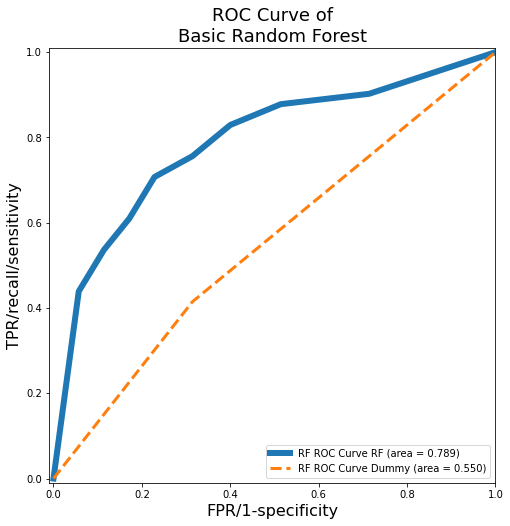

In [26]:
# Random Forest
# ROC AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, forest.predict_proba(X_val)[:, 1])
roc_auc_grd_rf = auc(fpr_rf, tpr_rf)

fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_val, dummy_clf.predict_proba(X_val)[:, 1])
roc_auc_grd_dummy = auc(fpr_dummy, tpr_dummy)

fig, ax = plt.subplots(figsize = (8,8))

plt.plot(fpr_rf, tpr_rf, label="RF ROC Curve RF (area = {:0.3f})".format(roc_auc_grd_rf), lw = 6)
plt.plot(fpr_dummy, tpr_dummy, label="RF ROC Curve Dummy (area = {:0.3f})".format(roc_auc_grd_dummy), lw = 3, linestyle='--')
# plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.xlabel("FPR/1-specificity", fontsize=16)
plt.ylabel("TPR/recall/sensitivity", fontsize=16)
plt.title('ROC Curve of\nBasic Random Forest', fontsize=18)
plt.legend(loc=4)

### Comment

As expected, Random Forest Classifier is easyly overfitted to the training data. It is indicated by the perfect accuracy on training set, but relatively poor accuracy on test set.<br>

`Accuracy on training set: 1.000` <br>
`Accuracy on validation set: 0.711`

Let's try parameter tuning using gridsearch.

In [27]:
# specify the model, first we will use random forest
# we will also check the best n estimator for the model
n_estimator = [5, 10, 25, 50, 100]
max_leaf_node = [5, 10, 25, 50, 100]

param_grid = [{'n_estimators': n_estimator, 
              'max_leaf_nodes': max_leaf_node},
              {'max_features': ['auto', 'sqrt'], 
              'bootstrap': [True, False], 
              'criterion':['entropy', 'gini']}]

rfcgrid = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, verbose=0, cv=10, n_jobs=-2)
rfcgrid.fit(X_train, y_train)

rfcgrid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=25,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [28]:
forest1 = RandomForestClassifier(bootstrap=True, 
                                 criterion='gini', 
                                 max_features='auto', 
                                 max_leaf_nodes=25,
                                 n_estimators=100,
                                 random_state=random_state)
forest1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=25,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=420,
                       verbose=0, warm_start=False)

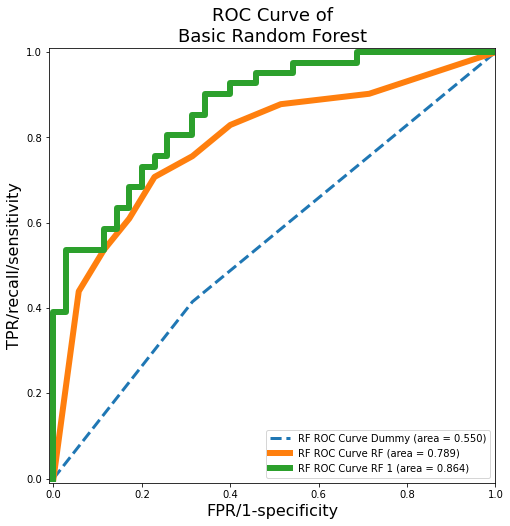

In [29]:
# Random Forest
# ROC AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, forest.predict_proba(X_val)[:, 1])
roc_auc_grd_rf = auc(fpr_rf, tpr_rf)

fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_val, dummy_clf.predict_proba(X_val)[:, 1])
roc_auc_grd_dummy = auc(fpr_dummy, tpr_dummy)

fpr_rf1, tpr_rf1, thresholds_rf1 = roc_curve(y_val, forest1.predict_proba(X_val)[:, 1])
roc_auc_grd_rf1 = auc(fpr_rf1, tpr_rf1)

fig, ax = plt.subplots(figsize = (8,8))

plt.plot(fpr_dummy, tpr_dummy, label="RF ROC Curve Dummy (area = {:0.3f})".format(roc_auc_grd_dummy), lw = 3, linestyle='--')
plt.plot(fpr_rf, tpr_rf, label="RF ROC Curve RF (area = {:0.3f})".format(roc_auc_grd_rf), lw = 6)
plt.plot(fpr_rf1, tpr_rf1, label="RF ROC Curve RF 1 (area = {:0.3f})".format(roc_auc_grd_rf1), lw = 6)
# plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.xlabel("FPR/1-specificity", fontsize=16)
plt.ylabel("TPR/recall/sensitivity", fontsize=16)
plt.title('ROC Curve of\nBasic Random Forest', fontsize=18)
plt.legend(loc=4)

As seen above, using `best_params_` from gridsearch, increase the AUC score of our random forest model, indicated by green line.